# Star Wars Object Detection Demo
This notebook will walk you step by step through the process of using a pre-trained model to detect R2-D2 and BB-8 in an image ([or a video](https://github.com/averdones/star_wars_object_detection/blob/master/object_detection_sw.ipynb)). 

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from utils import label_map_util
from utils import visualization_utils as vis_util

In [18]:
# This is needed to display the images.
%matplotlib inline
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("../models/research/object_detection/")

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.

In [4]:
# Frozen model dir.
MODEL_NAME = 'train/output_inference_graph.pb'
# Path to frozen detection graph.
PATH_TO_CKPT = '/Users/gsq/Desktop/Alex_Vild/Variant-ViLD/[6]-Transfer-Learning-eg/lab-2/' + MODEL_NAME + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/Users/gsq/Desktop/Alex_Vild/Variant-ViLD/[6]-Transfer-Learning-eg/lab-2/object_detection_self/data', 'sw_label_map.pbtxt')
NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
    od_graph_def = tf.GraphDef()
    
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        # frozen_inference_graph.pb as fid
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `1`, we know that this corresponds to `BB-8` and when it predicts `2`, we know it corresponds to `R2-D2`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
# label_map as:
# item {
#   name: "BB-8"
#   id: 1
# }
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
# categories as:
# [{'id': 1, 'name': 'BB-8'}, ...]
category_index = label_map_util.create_category_index(categories)
# category_index as:
# {1: {'id': 1, 'name': 'BB-8'}, 2: {}...}}

In [7]:
# Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection in images

In [27]:
PATH_TO_TEST_IMAGES_DIR = '/Users/gsq/Desktop/Alex_Vild/Variant-ViLD/[6]-Transfer-Learning-eg/lab-2/test_images'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.png'.format(i)) for i in range(15, 17) ]

IMAGE_SIZE = (16, 12) # Size, in inches, of the output images.

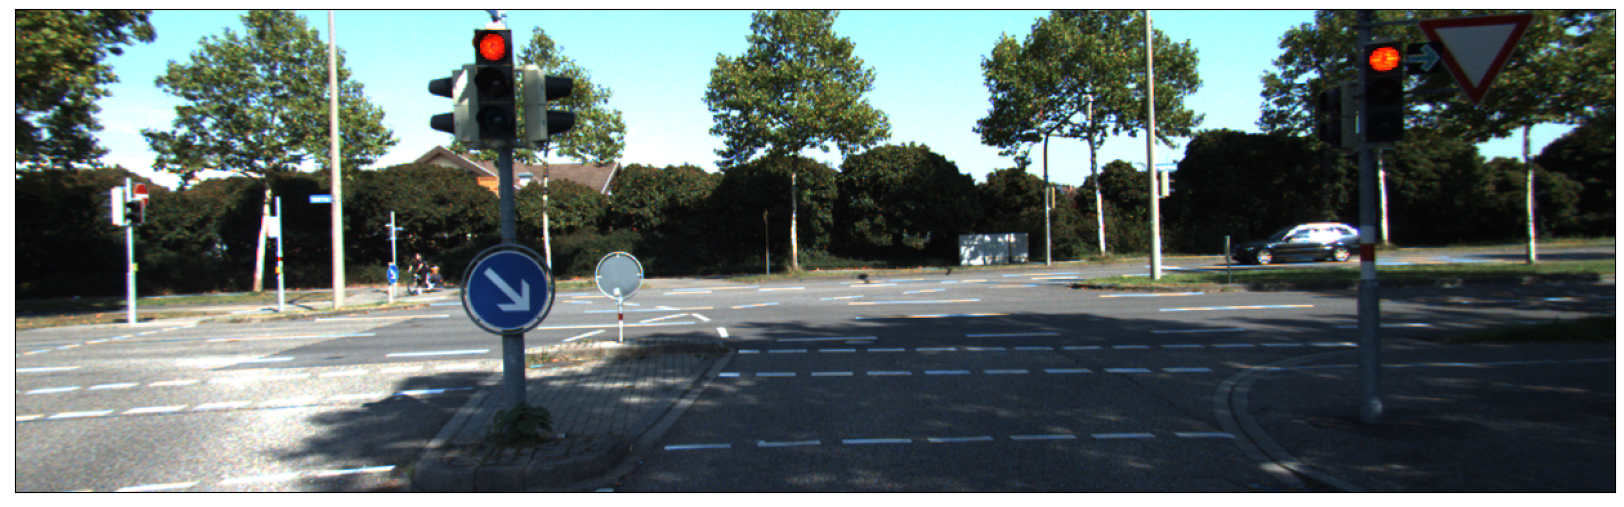

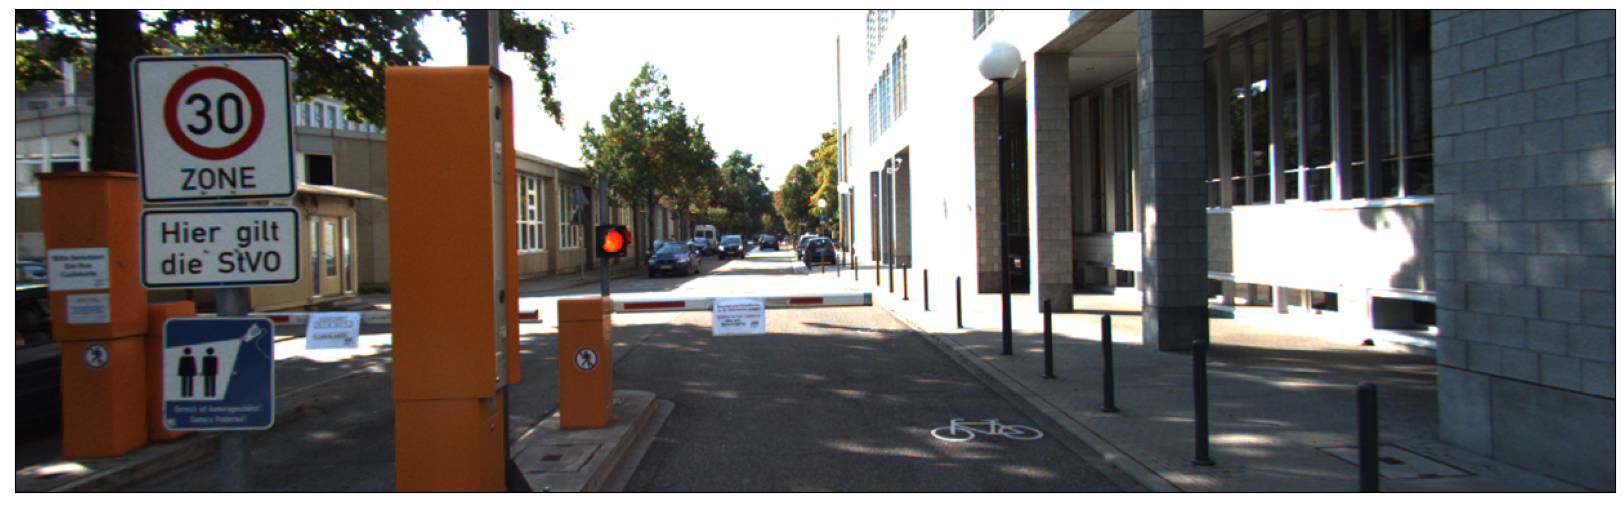

In [28]:
# detection_graph defined and loaded just now
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0') # Definite input and output Tensors for detection_graph
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0') # Each score represent confidence for each of the objects. Score is shown on the result image, together with the class label.
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            #! Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0) # (695, 1675, 3) > (1, 695, 1675, 3)
            
            ### Actual detection ###
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            ### Visualization of the results of a detection ###
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True, line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
            plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
            plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
            plt.margins(0, 0)
            plt.imshow(image_np)
            #plt.show()